In [2]:
from __future__ import absolute_import, division, print_function
import sys
import collections 

import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100, cifar10
from tqdm import tqdm
from IPython.display import clear_output

from scan_tf.models.resnet import resnet_18, resnet_34, resnet_50, resnet_101, resnet_152, add_classification_layer
import scan_tf.utils.utils as utils


# Grow memory to avoid mem overflow
memory_growth=True
if memory_growth:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
      except RuntimeError as e:
        print(e)

In [3]:
# Model configuration
img_width, img_height, img_num_channels = 32, 32, 3
no_epochs = 100
optimizer = tf.keras.optimizers.Adam()
validation_split = 0.2
verbosity = 1

# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:10000]
y_train = y_train[:10000]



X_train.shape
input_train = X_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Find number of classes dynamically
num_classes = y_train.shape[1]

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Normalize data
X_train = (X_train / 255).astype(np.float32)
X_test = (X_test / 255).astype(np.float32)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape : {X_train.shape}")
print(f"y_test shape : {y_test.shape}")

X_train shape: (10000, 32, 32, 3)
y_train shape: (10000, 10)
X_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 10)


In [4]:
model = resnet_18(n_output=128)
model.build(input_shape=(None, img_width, img_height, img_num_channels))
model.summary()

Model: "res_net_type_i"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  148736    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  527488    
_________________________________________________________________
sequential_3 (Sequential)    multiple                  2103552   
_________________________________________________________________
sequential_5 (Sequential)    multiple               

In [5]:
# model.load_weights("resnet18_classification_with_rotnet.h5")

In [6]:
# model = tf.keras.models.load_model('resnet18_classification_with_rotnet.h5')
# # latest = tf.train.latest_checkpoint(checkpoint_dir)
# # # Load the previously saved weights
# # model.load_weights(latest)


# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

<h3>Training for minimizing the Rotation Loss</h3>

In [7]:
def pretext_training(model, X_train, y_train):
    lr = 1e-4
    e = 0
    m = X_train.shape[0]
    batch_size = 128

    while True:
        e+=1
        batch_count = 0
    #     for idx in tqdm(range(0, m, batch_size)): # batch
        for idx in range(0, m, batch_size): # batch
            images = tf.convert_to_tensor(X_train[idx:idx+batch_size, ...])
            labels = tf.convert_to_tensor(y_train[idx:idx+batch_size, ...])

            degrees_to_rotate = np.random.choice([90, 180, 270]) # randomly choosing the rotation angle

            images_rotated = tf.convert_to_tensor(scipy.ndimage.rotate(images, degrees_to_rotate, axes=(2, 1))) 

            with tf.GradientTape() as tape:
                embs_a, embs_b = model(images), model(images_rotated)
    #             loss = tf.norm(embs_a-embs_b, ord='euclidean', axis=None, keepdims=None, name=None)
                loss = tf.reduce_sum(tf.norm(embs_a-embs_b, ord='euclidean', axis=(1), keepdims=None, name=None))

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer = tf.keras.optimizers.Adam(lr=lr)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            batch_count+=1
        if e%1 == 0:
            #clear_output()
            print(f"epoch {e}, loss: {loss}")
        if e==20:
            break
    return model
pretext_training(model, X_train, y_train)

epoch 1, loss: 0.0108400359749794
epoch 2, loss: 0.001389570301398635
epoch 3, loss: 0.0004986482672393322
epoch 4, loss: 0.00027070441865362227
epoch 5, loss: 0.00039096749969758093
epoch 6, loss: 8.554082887712866e-05
epoch 7, loss: 6.220406794454902e-05
epoch 8, loss: 3.54471048922278e-05
epoch 9, loss: 1.9451368643785827e-05
epoch 10, loss: 1.2394833902362734e-05
epoch 11, loss: 8.506686754117254e-06
epoch 12, loss: 7.120283953554463e-06
epoch 13, loss: 9.02740521269152e-06
epoch 14, loss: 4.020859250886133e-06
epoch 15, loss: 2.759750032055308e-06
epoch 16, loss: 4.039857685711468e-06
epoch 17, loss: 4.279939275875222e-06
epoch 18, loss: 2.3183374651125632e-06
epoch 19, loss: 2.232070983154699e-06
epoch 20, loss: 7.709876626904588e-06


In [8]:
model.save_weights("resnet18_classification_with_rotnet.h5")

In [9]:
embeddings = model.predict(images)
print(f"Embeddings shape {embeddings.shape}")

Embeddings shape (16, 128)


<h3>Finding Nearest Neighbors</h3>

In [9]:
nn = utils.CLusteringNN(model, n_neighbors=5)
nn.fit(images)
print(nn.get_neighbors_indexes(images[0]))

[[ 0 46 15 75 58]]


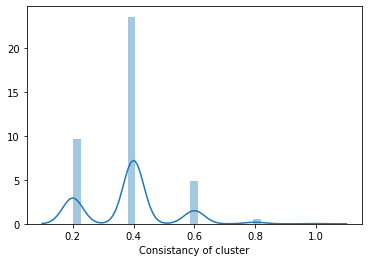

In [10]:
def find_neighbor_consistancy(images, labels, n_neighbors=5, plot=False):
    nn = utils.CLusteringNN(model, n_neighbors=5)
    nn.fit(images)
    nn_indexes = nn.get_neighbors_indexes(images)
    consistancies = list()
    true_classes = np.argmax(labels, axis=1)
    for cluster_indexes in nn_indexes:
        cluster_classes = true_classes[cluster_indexes]
        # Not sure which formula is better
        consistancy = (cluster_classes[1:]==cluster_classes[0]).sum()/(len(cluster_indexes)-1)
        # Not sure which formula is better
        cluster_label_counter = collections.Counter(cluster_classes)
        consistancy = cluster_label_counter.most_common()[0][1]/len(cluster_indexes)
        consistancies.append(consistancy)

    if plot:
        sns.distplot(consistancies)
    plt.xlabel("Consistancy of cluster")
    return consistancies
consistancies = find_neighbor_consistancy(X_train, y_train, n_neighbors=5, plot=True)

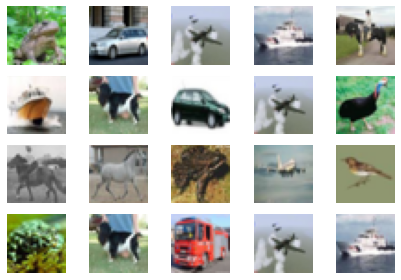

In [11]:
# Show center of cluster (first column) and cluster
def show_neighbors(images, labels, n_neighbors=5):
    nn = utils.CLusteringNN(model, n_neighbors=5)
    nn.fit(images)
    nn_indexes = nn.get_neighbors_indexes(images)
    consistancies = list()
    true_classes = np.argmax(labels, axis=1)
    n = 4
    f, axes = plt.subplots(n, n_neighbors)
    for i, cluster_indexes in enumerate(nn_indexes[:n]):
        for j, im_i in enumerate(cluster_indexes):
            axes[i,j].axis('off')
            axes[i,j].imshow(images[im_i])
    plt.tight_layout()
    plt.show()

show_neighbors(images, labels, n_neighbors=5)


## Semantic Clustering

In [25]:
def semantic_clustering_training(base_model, X_train, y_train):
    base_model.load_weights("resnet18_classification_with_rotnet.h5")
    num_classes = y_train.shape[1]
    model = add_classification_layer(base_model, num_classes)
    
    n_neighbors = 5
    lr = 1e-4
    e = 0
    m = X_train.shape[0]
    batch_size = 128
    k = 0.5
    
    # Get clusters
    nn = utils.CLusteringNN(model, n_neighbors=n_neighbors)
    nn.fit(X_train)
    nn_indexes = nn.get_neighbors_indexes(X_train)

    while True:
        e+=1
        batch_count = 0
        for batch_count in range(m//batch_size): # batch
            images_indexes = []
            cluster_images_indexes = []
            batch_ids = np.random.choice(range(0, m), batch_size)
            for i in batch_ids:
                images_indexes += [nn_indexes[i][0]]*(n_neighbors-1)
                cluster_images_indexes += list(nn_indexes[i][1:])
            images = tf.convert_to_tensor(X_train[images_indexes, ...])
            cluster_images = tf.convert_to_tensor(X_train[cluster_images_indexes, ...])

            with tf.GradientTape() as tape:
                images_pred, cluster_images_pred = model(images), model(cluster_images)
                norm = tf.norm(images_pred-cluster_images_pred, ord='euclidean', axis=(1), keepdims=None, name=None)
                consistant_loss = tf.reduce_sum(tf.math.log(norm))
                
                _ = tf.reduce_sum(images_pred, 0) / len(images)
                entropy_loss = tf.reduce_sum(_ * tf.math.log(_))
                loss = consistant_loss + entropy_loss

                grads = tape.gradient(loss, model.trainable_weights)
                optimizer = tf.keras.optimizers.Adam(lr=lr)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if e%1 == 0:
            #clear_output()
            print(f"epoch {e}, loss: {consistant_loss:.2f} + {k}*{entropy_loss:.2f}={loss:.3f}")
        if e==20:
            break
semantic_clustering_training(model, X_train, y_train)

epoch 1, loss: -6638.70 + 0.5*-2.30=-6641.000
epoch 2, loss: -6697.87 + 0.5*-2.30=-6700.167
epoch 3, loss: -6752.78 + 0.5*-2.30=-6755.081
epoch 4, loss: -6800.10 + 0.5*-2.30=-6802.399
epoch 5, loss: -6797.38 + 0.5*-2.30=-6799.686
epoch 6, loss: -6760.90 + 0.5*-2.30=-6763.207
epoch 7, loss: -6992.56 + 0.5*-2.30=-6994.859
epoch 8, loss: -6989.79 + 0.5*-2.30=-6992.097
epoch 9, loss: -7028.18 + 0.5*-2.30=-7030.482
epoch 10, loss: -7099.72 + 0.5*-2.30=-7102.026
epoch 11, loss: -7089.10 + 0.5*-2.30=-7091.400
epoch 12, loss: -7167.40 + 0.5*-2.30=-7169.702
epoch 13, loss: -7214.03 + 0.5*-2.30=-7216.335
epoch 14, loss: -7226.06 + 0.5*-2.30=-7228.364
epoch 15, loss: -7222.91 + 0.5*-2.30=-7225.214
epoch 16, loss: -7256.03 + 0.5*-2.30=-7258.326
epoch 17, loss: -7329.00 + 0.5*-2.30=-7331.305
epoch 18, loss: -7219.13 + 0.5*-2.30=-7221.428
epoch 19, loss: -7325.16 + 0.5*-2.30=-7327.460
epoch 20, loss: -7401.58 + 0.5*-2.30=-7403.881
